<a href="https://colab.research.google.com/github/sarahfirouzabadi/Summer-2025-ECE-597-Group5/blob/main/Summer_2025_ECE_597_Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from scipy.sparse import hstack, csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
TFIDV=TfidfVectorizer()

In [28]:
CEAS=pd.read_csv('/CEAS_08.csv')
CEAS.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [29]:
label_counts = CEAS['label'].value_counts().sort_index()
num_ham = label_counts.get(0, 0)
num_spam = label_counts.get(1, 0)

print(f"CEAS:\nHam: {num_ham}\nSpam: {num_spam}")

CEAS:
Ham: 17312
Spam: 21842


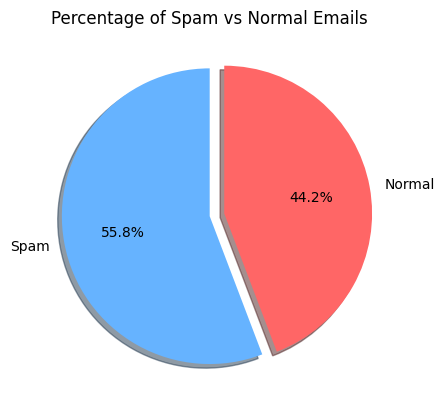

In [30]:
email_counts = CEAS['label'].value_counts().rename({0: 'Normal', 1: 'Spam'})

email_counts.plot.pie(
    autopct='%1.1f%%',
    colors=['#66b3ff','#ff6666'],
    startangle=90,
    explode=(0, 0.1),
    shadow=True
)

plt.title('Percentage of Spam vs Normal Emails')
plt.ylabel('')  # remove default y-axis label

plt.show()

In [31]:
SpamAssasin = pd.read_csv('/SpamAssasin.csv')
SpamAssasin.head()

,sender,receiver,date,subject,body,label,urls
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1


In [32]:
label_counts = SpamAssasin['label'].value_counts().sort_index()
num_ham = label_counts.get(0, 0)
num_spam = label_counts.get(1, 0)

print(f"SpamAssasin:\nHam: {num_ham}\nSpam: {num_spam}")

SpamAssasin:
Ham: 4091
Spam: 1718


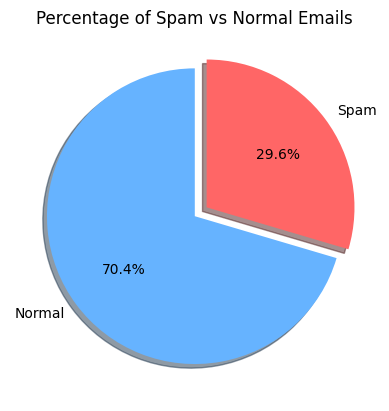

In [33]:
email_counts = SpamAssasin['label'].value_counts().rename({0: 'Normal', 1: 'Spam'})

email_counts.plot.pie(
    autopct='%1.1f%%',
    colors=['#66b3ff','#ff6666'],
    startangle=90,
    explode=(0, 0.1),
    shadow=True
)

plt.title('Percentage of Spam vs Normal Emails')
plt.ylabel('')

plt.show()

In [34]:
Nazario = pd.read_csv('/Nazario.csv')
Nazario.head()

,sender,receiver,date,subject,body,urls,label
0,Mail System Internal Data <MAILER-DAEMON@monke...,NaN,28 Sep 2017 09:57:25 -0400,DON'T DELETE THIS MESSAGE -- FOLDER INTERNAL DATA,This text is part of the internal format of yo...,1,1
1,cPanel <service@cpanel.com>,jose@monkey.org,"Fri, 30 Oct 2015 00:00:48 -0500",Verify Your Account,Business with \t\t\t\t\t\t\t\tcPanel & WHM \t...,1,1
2,Microsoft Outlook <recepcao@unimedceara.com.br>,NaN,"Fri, 30 Oct 2015 06:21:59 -0300 (BRT)",Helpdesk Mailbox Alert!!!,Your two incoming mails were placed on pending...,1,1
3,Ann Garcia <AnGarcia@mcoe.org>,"""info@maaaaa.org"" <info@maaaaa.org>","Fri, 30 Oct 2015 14:54:33 +0000",IT-Service Help Desk,Password will expire in 3 days. Click Here To ...,0,1
4,"""USAA"" <usaaacctupdate@sccu4u.com>",Recipients <usaaacctupdate@sccu4u.com>,"Fri, 30 Oct 2015 14:02:33 -0500",Final USAA Reminder - Update Your Account Now,"To ensure delivery to your inbox, please add U...",1,1


In [35]:
label_counts = Nazario['label'].value_counts().sort_index()
num_ham = label_counts.get(0, 0)
num_spam = label_counts.get(1, 0)

print(f"Nazario:\nHam: {num_ham}\nSpam: {num_spam}")

Nazario:
Ham: 0
Spam: 1565


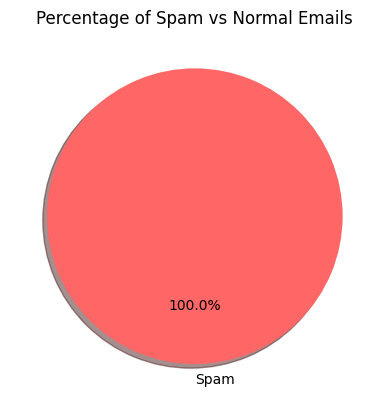

In [36]:
email_counts = Nazario['label'].value_counts().rename({0: 'Normal', 1: 'Spam'})

email_counts.plot.pie(
    autopct='%1.1f%%',
    colors=['#ff6666'],
    startangle=90,
    shadow=True
)

plt.title('Percentage of Spam vs Normal Emails')
plt.ylabel('')

plt.show()

In [37]:
Nigerian_Fraud = pd.read_csv('/Nigerian_Fraud.csv')
Nigerian_Fraud.head()

,sender,receiver,date,subject,body,urls,label
0,MR. JAMES NGOLA. <james_ngola2002@maktoob.com>,webmaster@aclweb.org,"Thu, 31 Oct 2002 02:38:20 +0000",URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...,0,1
1,Mr. Ben Suleman <bensul2004nng@spinfinder.com>,R@M,"Thu, 31 Oct 2002 05:10:00 -0000",URGENT ASSISTANCE /RELATIONSHIP (P),"Dear Friend,\n\nI am Mr. Ben Suleman a custom ...",0,1
2,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,"Thu, 31 Oct 2002 22:17:55 +0100",GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1
3,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,"Thu, 31 Oct 2002 22:44:20 -0000",GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1
4,Maryam Abacha <m_abacha03@www.com>,R@M,"Fri, 01 Nov 2002 01:45:04 +0100",I Need Your Assistance.,"Dear sir, \n \nIt is with a heart full of hope...",0,1


In [38]:
label_counts = Nigerian_Fraud['label'].value_counts().sort_index()
num_ham = label_counts.get(0, 0)
num_spam = label_counts.get(1, 0)

print(f"Nigerian_Fraud:\nHam: {num_ham}\nSpam: {num_spam}")

Nigerian_Fraud:
Ham: 0
Spam: 3332


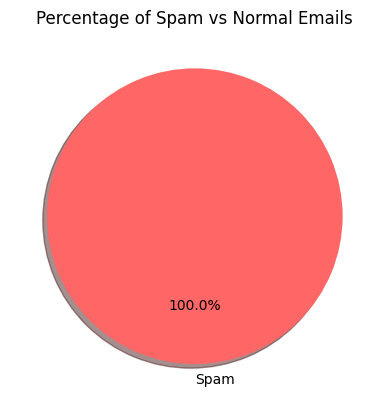

In [39]:
email_counts = Nigerian_Fraud['label'].value_counts().rename({0: 'Normal', 1: 'Spam'})

email_counts.plot.pie(
    autopct='%1.1f%%',
    colors=['#ff6666'],
    startangle=90,
    shadow=True
)

plt.title('Percentage of Spam vs Normal Emails')
plt.ylabel('')

plt.show()

In [40]:
# Combine datasets and removing unnecessary coloumns
combined_df = pd.concat([
    CEAS[['sender', 'subject', 'body', 'label']],
    SpamAssasin[['sender', 'subject', 'body', 'label']],
    Nazario[['sender', 'subject', 'body', 'label']],
    Nigerian_Fraud[['sender', 'subject', 'body', 'label']]
], ignore_index=True)

print(combined_df.head())
print(f"Combined DataFrame shape: {combined_df.shape}")

                                              sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   

                                             subject  \
0                          Never agree to be a loser   
1                             Befriend Jenna Jameson   
2                               CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/tru...   
4                         SpecialPricesPharmMoreinfo   

                                                body  label  
0  Buck up, your troubles caused by small dimensi...      1  
1  \nUpgrade your sex and pleasures with these te...      1  
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...      1  
3  Would anyone object to removing .so from this ...      0  
4  \nWelcomeFast

In [41]:
# Remove duplicates
combined_df.drop_duplicates(subset=['sender', 'subject', 'body'], inplace=True)

# Missing values
print(combined_df.isnull().sum())

# Drop rows with missing sender, subject, or body
combined_df.dropna(subset=['sender', 'subject', 'body'], inplace=True)

combined_df.reset_index(drop=True, inplace=True)
print(f'Cleaned dataset shape: {combined_df.shape}')

sender     331
subject     87
body         1
label        0
dtype: int64
Cleaned dataset shape: (49446, 4)


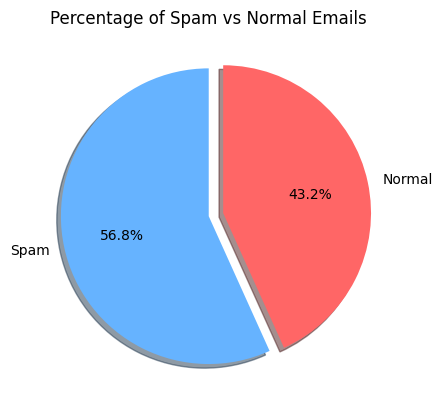

In [42]:
# Count spam and normal emails
email_counts = combined_df['label'].value_counts().rename({0: 'Normal', 1: 'Spam'})

# Plot a pie chart
email_counts.plot.pie(
    autopct='%1.1f%%',
    colors=['#66b3ff','#ff6666'],
    startangle=90,
    explode=(0, 0.1),
    shadow=True
)

plt.title('Percentage of Spam vs Normal Emails')
plt.ylabel('')  # remove default y-axis label

plt.show()

Down sampling (Reducing spam size)

In [43]:
spam = combined_df[combined_df.label == 1]
normal = combined_df[combined_df.label == 0]

# Downsample spam class to match normal class size
spam_downsampled = resample(spam,
                            replace=False,
                            n_samples=len(normal),
                            random_state=42)

# Combine them all again
balanced_df = pd.concat([spam_downsampled, normal])

# Shuffle rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


print(balanced_df['label'].value_counts())

label
0    21384
1    21384
Name: count, dtype: int64


In [44]:
balanced_df.info()
balanced_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42768 entries, 0 to 42767
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sender   42768 non-null  object
 1   subject  42768 non-null  object
 2   body     42768 non-null  object
 3   label    42768 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


,sender,subject,body,label
0,bmr-lpwzlkvw-nerqhbm@satellite.ac.nz,"Welcome to the ""Asa-postgrad"" mailing list",Welcome to the cfu-jyrkrnuq@satellite.ac.nz ma...,0
1,"""Darragh Rogan"" <lists@roganmedia.com>",RE: [IIU] Recommendations on phone / pda+phone...,o2 xda? Darragh -----Original Message----- Fro...,0
2,Kazules <Bonny-bassigna@138files.com>,5 moves to help slim your lower half,Beach affairs. How long they last? http://www....,1
3,Daily Top 10 <melkpoed@statkraft.no>,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
4,Samuele Pedroni <fuozscyl@openend.se>,Re: [Python-Dev] PEP 8: Discourage named lambdas?,Nick Coghlan wrote:\n> Samuele Pedroni wrote:\...,0


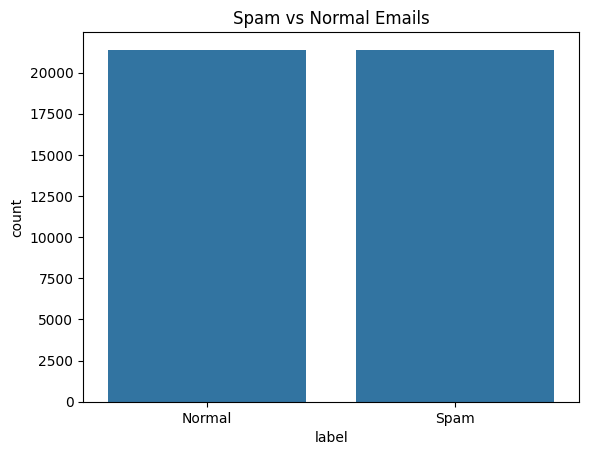

In [45]:
sns.countplot(x='label', data=balanced_df)
plt.title('Spam vs Normal Emails')
plt.xticks([0, 1], ['Normal', 'Spam'])
plt.show()

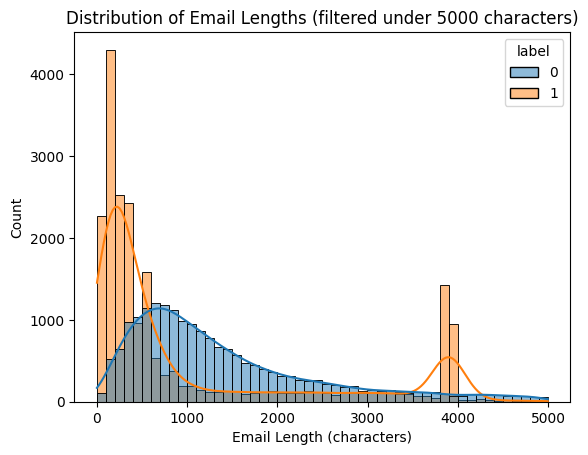

In [46]:
balanced_df['email_length'] = balanced_df['body'].fillna('').str.len()

filtered_df = balanced_df[balanced_df['email_length'] < 5000]

# Plot the filtered data
sns.histplot(data=filtered_df, x='email_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Email Lengths (filtered under 5000 characters)')
plt.xlabel('Email Length (characters)')
plt.show()

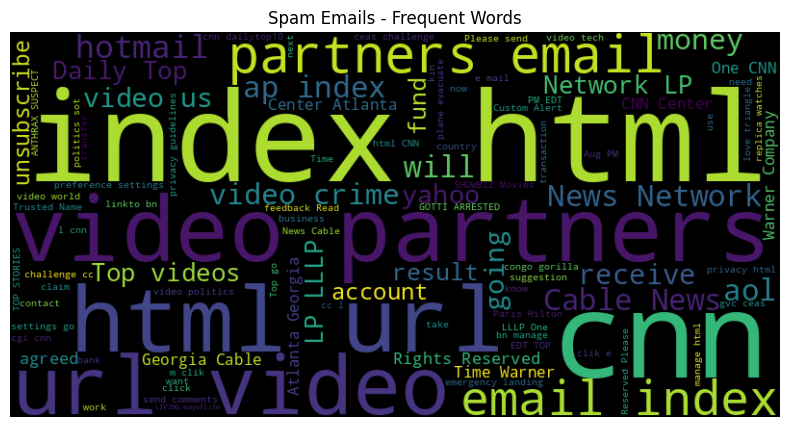

In [47]:
spam_words = ' '.join(balanced_df[balanced_df['label']==1]['body'].dropna())
wordcloud_spam = WordCloud(width=800, height=400, max_words=100).generate(spam_words)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Spam Emails - Frequent Words')
plt.axis('off')
plt.show()

In [48]:
# Download stopwords once
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Initialize counter
word_counter = Counter()

# Loop through spam emails line by line (avoids joining the full string)
for text in balanced_df[balanced_df['label'] == 1]['body'].dropna():
    # Lowercase, remove punctuation/numbers, tokenize
    words = re.findall(r'\b[a-z]+\b', text.lower())

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Update counter
    word_counter.update(filtered_words)

# Show top 50
print("Top 50 frequent words in spam emails:")
for word, freq in word_counter.most_common(50):
    print(f"{word}: {freq}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top 50 frequent words in spam emails:
com: 109384
cnn: 86078
http: 68159
www: 56744
html: 51489
video: 46782
index: 46437
email: 33917
url: 23158
partners: 23137
us: 17771
top: 12498
crime: 12158
news: 10494
money: 8754
account: 8471
please: 8164
hotmail: 7817
one: 7529
world: 7088
ap: 7001
network: 6938
cable: 6789
settings: 6787
time: 6744
company: 6707
e: 6668
aol: 6518
net: 6455
name: 6328
privacy: 6180
bank: 6130
go: 6067
receive: 5846
manage: 5787
click: 5575
going: 5454
politics: 5394
yahoo: 5335
obama: 5293
mail: 5000
get: 4729
daily: 4713
videos: 4660
stories: 4642
lp: 4605
lllp: 4576
business: 4553
send: 4474
life: 4445


In [49]:
def tokenize(text):
    text = str(text).lower()
    words = re.findall(r'\b[a-z]+\b', text)  # only alphabetic words
    return [w for w in words if w not in stop_words]

# Apply tokenization
balanced_df['tokens'] = balanced_df['body'].apply(tokenize)

# Separate phishing and normal
phishing_tokens = balanced_df[balanced_df['label'] == 1]['tokens']
normal_tokens = balanced_df[balanced_df['label'] == 0]['tokens']

# Average words
avg_words_phishing = phishing_tokens.apply(len).mean()
avg_words_normal = normal_tokens.apply(len).mean()

# Flatten token lists
flat_phishing = [word for tokens in phishing_tokens for word in tokens]
flat_normal = [word for tokens in normal_tokens for word in tokens]

# Unique word counts
unique_phishing = len(set(flat_phishing))
unique_normal = len(set(flat_normal))

# Most indicative phishing words (appearing more in phishing than in normal)
phishing_counter = Counter(flat_phishing)
normal_counter = Counter(flat_normal)

indicative_phishing = {
    word: freq for word, freq in phishing_counter.items()
    if freq > normal_counter.get(word, 0)
}

top_indicative = Counter(indicative_phishing).most_common(20)

print(f"Average words per phishing email: {avg_words_phishing:.2f}")
print(f"Total unique words in phishing emails: {unique_phishing}")

print(f"Average words per normal email: {avg_words_normal:.2f}")
print(f"Total unique words in normal emails: {unique_normal}")

print("\nTop 20 words most indicative of phishing:")
for word, freq in top_indicative:
    print(f"{word}: {freq}")

Average words per phishing email: 120.63
Total unique words in phishing emails: 81119
Average words per normal email: 215.75
Total unique words in normal emails: 105622

Top 20 words most indicative of phishing:
com: 109384
cnn: 86078
http: 68159
www: 56744
html: 51489
video: 46782
index: 46437
email: 33917
url: 23158
partners: 23137
us: 17771
top: 12498
crime: 12158
news: 10494
money: 8754
account: 8471
please: 8164
hotmail: 7817
world: 7088
ap: 7001


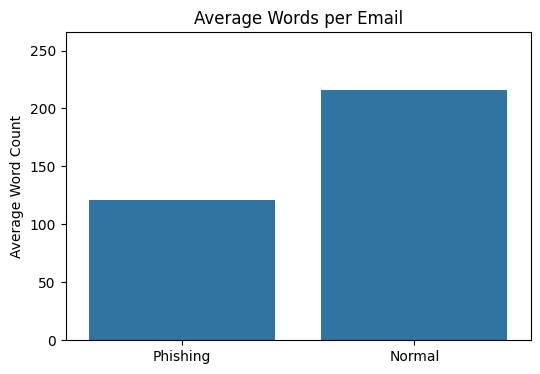

In [50]:
# Average words data
avg_words = {'Phishing': 120.63, 'Normal': 215.75}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(avg_words.keys()), y=list(avg_words.values()))
plt.title('Average Words per Email')
plt.ylabel('Average Word Count')
plt.ylim(0, max(avg_words.values()) + 50)
plt.show()

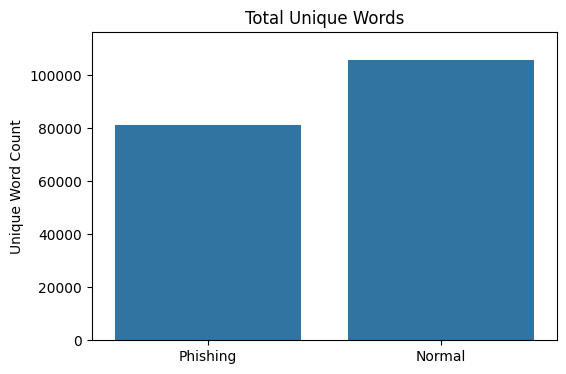

In [51]:
# Unique words data
unique_words = {'Phishing': 81119, 'Normal': 105622}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(unique_words.keys()), y=list(unique_words.values()))
plt.title('Total Unique Words')
plt.ylabel('Unique Word Count')
plt.ylim(0, max(unique_words.values()) * 1.1)
plt.show()


Subject

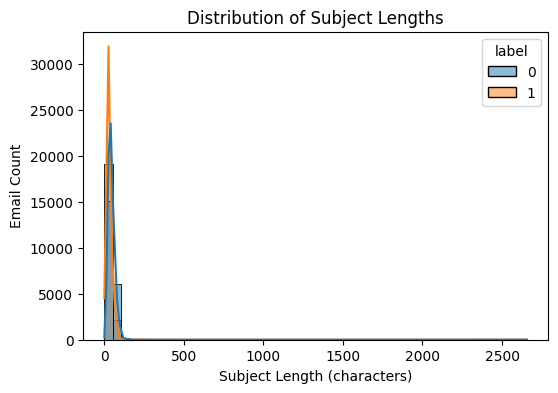

In [52]:
balanced_df['subject_length'] = balanced_df['subject'].fillna('').apply(len)

plt.figure(figsize=(6,4))
sns.histplot(data=balanced_df, x='subject_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Subject Lengths')
plt.xlabel('Subject Length (characters)')
plt.ylabel('Email Count')
plt.show()


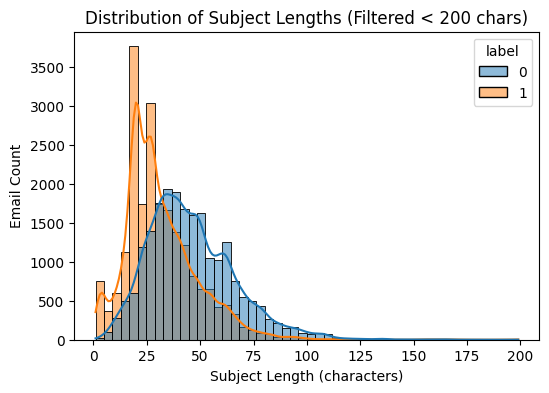

In [53]:
# Filter out very long subjects
filtered_subject_df = balanced_df[balanced_df['subject_length'] < 200]

plt.figure(figsize=(6,4))
sns.histplot(data=filtered_subject_df, x='subject_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Subject Lengths (Filtered < 200 chars)')
plt.xlabel('Subject Length (characters)')
plt.ylabel('Email Count')
plt.show()

In [54]:
avg_len_spam = balanced_df[balanced_df['label'] == 1]['subject_length'].mean()
avg_len_normal = balanced_df[balanced_df['label'] == 0]['subject_length'].mean()

print(f"Average subject length - Phishing: {avg_len_spam:.2f}")
print(f"Average subject length - Normal: {avg_len_normal:.2f}")

Average subject length - Phishing: 31.68
Average subject length - Normal: 45.92


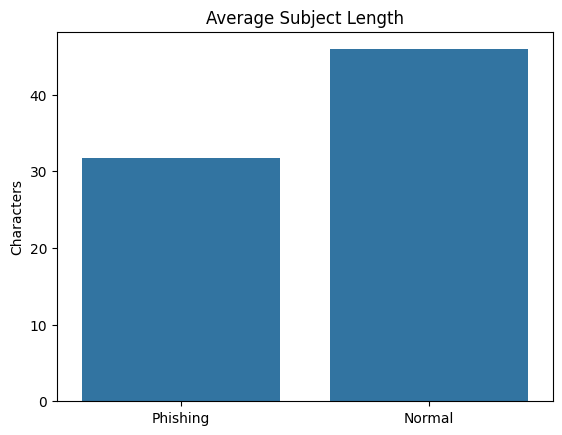

In [55]:
sns.barplot(x=['Phishing', 'Normal'], y=[avg_len_spam, avg_len_normal])
plt.title('Average Subject Length')
plt.ylabel('Characters')
plt.show()

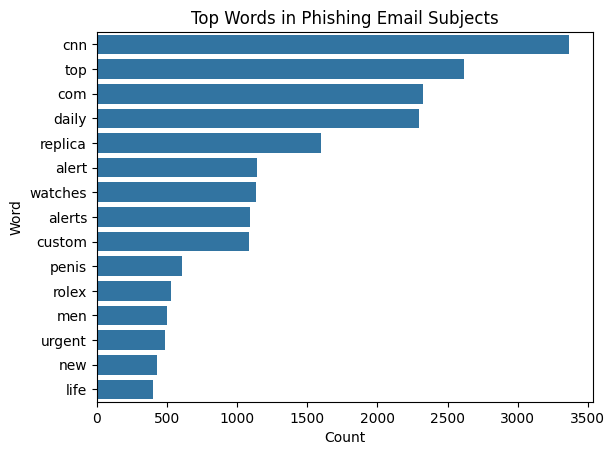

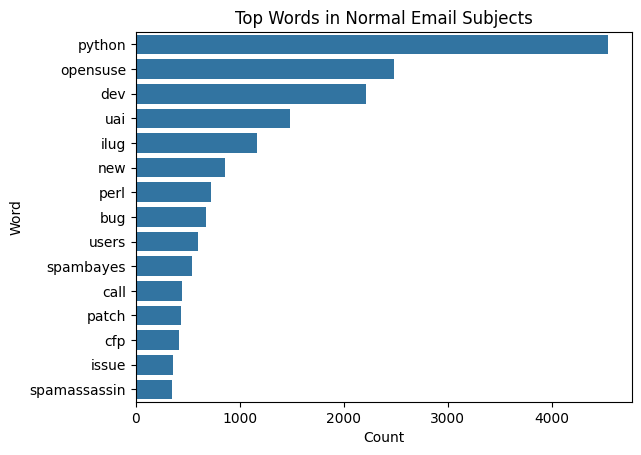

In [56]:
stop_words = set(stopwords.words('english'))

def clean_subject(text):
    words = re.findall(r'\b[a-z]+\b', str(text).lower())
    return [w for w in words if w not in stop_words]

# Tokenize spam and normal subjects
spam_subject_words = balanced_df[balanced_df['label'] == 1]['subject'].dropna().apply(clean_subject)
normal_subject_words = balanced_df[balanced_df['label'] == 0]['subject'].dropna().apply(clean_subject)

# Flatten
spam_subject_flat = [word for words in spam_subject_words for word in words]
normal_subject_flat = [word for words in normal_subject_words for word in words]

# Count top words
spam_top_subject = Counter(spam_subject_flat).most_common(15)
normal_top_subject = Counter(normal_subject_flat).most_common(15)

# For spam
df_spam_subject = pd.DataFrame(spam_top_subject, columns=['Word', 'Count'])
sns.barplot(data=df_spam_subject, y='Word', x='Count')
plt.title('Top Words in Phishing Email Subjects')
plt.show()

# For normal
df_normal_subject = pd.DataFrame(normal_top_subject, columns=['Word', 'Count'])
sns.barplot(data=df_normal_subject, y='Word', x='Count')
plt.title('Top Words in Normal Email Subjects')
plt.show()


Extracting the Domain

In [57]:
balanced_df["sender_2"]=balanced_df['sender'].str.split('@').str[1]

In [58]:
balanced_df["sender_2"].value_counts()

,count
sender_2,
gmail.com>,2636
spamassassin.taint.org>,595
hotmail.com>,532
python.org>,526
issues.apache.org,462
...,...
lansystem.com>,1
boegerwinery.com>,1
thegoldsteingroup.com>,1


Data cleaning

In [59]:
def clean_and_tokenize(text):
    text = str(text).lower()                             # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)                 # Remove punctuation and numbers
    tokens = text.split()                                # Tokenize by whitespace
    tokens = [t for t in tokens if t not in stop_words]  # Remove stopwords
    return tokens


balanced_df['body_tokens'] = balanced_df['body'].fillna('').apply(clean_and_tokenize)
balanced_df['subject_tokens'] = balanced_df['subject'].fillna('').apply(clean_and_tokenize)

print("Sample cleaned body:", balanced_df['body_tokens'].iloc[0])
print("Sample cleaned subject:", balanced_df['subject_tokens'].iloc[0])

Sample cleaned body: ['welcome', 'cfujyrkrnuqsatelliteacnz', 'mailing', 'list', 'welcome', 'asa', 'mailing', 'list', 'thank', 'joining', 'hope', 'find', 'emails', 'informative', 'useful', 'post', 'list', 'send', 'email', 'cfujyrkrnuqsatelliteacnz', 'general', 'information', 'mailing', 'list', 'httplistssatelliteacnzmailmanlistinfoasapostgrad', 'ever', 'want', 'unsubscribe', 'change', 'options', 'eg', 'switch', 'digest', 'mode', 'change', 'password', 'etc', 'visit', 'subscription', 'page', 'httplistssatelliteacnzmailmanoptionsasapostgradtameyermasseyacnz', 'also', 'make', 'adjustments', 'via', 'email', 'sending', 'message', 'bmrlpwzlkvwnerqhbmsatelliteacnz', 'word', 'help', 'subject', 'body', 'dont', 'include', 'quotes', 'get', 'back', 'message', 'instructions', 'must', 'know', 'password', 'change', 'options', 'including', 'changing', 'password', 'unsubscribe', 'ovavogwo', 'normally', 'mailman', 'remind', 'satelliteacnz', 'mailing', 'list', 'passwords', 'every', 'month', 'although', 'di

Feature engineering

In [60]:
# Email body length
balanced_df['email_length'] = balanced_df['body'].fillna('').str.len()

# Subject length
balanced_df['subject_length'] = balanced_df['subject'].fillna('').str.len()

# Number of words in the body
balanced_df['body_word_count'] = balanced_df['body_tokens'].apply(len)

# Number of words in the subject
balanced_df['subject_word_count'] = balanced_df['subject_tokens'].apply(len)

# Number of URLs
url_pattern = r'(https?://[^\s]+)' # Define a URL regex pattern
balanced_df['num_urls'] = balanced_df['body'].fillna('').apply(lambda x: len(re.findall(url_pattern, x)))

# Sender domain
balanced_df['sender_domain'] = balanced_df['sender'].fillna('').str.extract(r'@([\w\.-]+)')

# Preview engineered features
balanced_df[['email_length', 'subject_length', 'body_word_count', 'subject_word_count',
             'num_urls', 'sender_domain']].head()


,email_length,subject_length,body_word_count,subject_word_count,num_urls,sender_domain
0,1303,42,97,4,2,satellite.ac.nz
1,1803,77,145,8,3,roganmedia.com
2,60,36,5,5,1,138files.com
3,3895,20,182,3,24,statkraft.no
4,962,49,64,5,2,openend.se


TF-IDF

In [61]:
# Join tokens back to strings
balanced_df['body_clean'] = balanced_df['body_tokens'].apply(lambda x: ' '.join(x))
balanced_df['subject_clean'] = balanced_df['subject_tokens'].apply(lambda x: ' '.join(x))
balanced_df['sender_domain_clean'] = balanced_df['sender_domain'].fillna('')

# body
tfidf_body = TfidfVectorizer(stop_words='english', max_features=3000)
X_body = tfidf_body.fit_transform(balanced_df['body_clean'])

# subject
tfidf_subject = TfidfVectorizer(stop_words='english', max_features=1000)
X_subject = tfidf_subject.fit_transform(balanced_df['subject_clean'])

# sender domain
tfidf_sender = TfidfVectorizer()
X_sender = tfidf_sender.fit_transform(balanced_df['sender_domain_clean'])

print("TF-IDF shape (body):", X_body.shape)
print("TF-IDF shape (subject):", X_subject.shape)
print("TF-IDF shape (sender):", X_sender.shape)

TF-IDF shape (body): (42768, 3000)
TF-IDF shape (subject): (42768, 1000)
TF-IDF shape (sender): (42768, 16691)


Train Logistic Regression and Random Forest

In [62]:
y = balanced_df['label']

numeric_cols = [
    'email_length',
    'subject_length',
    'body_word_count',
    'subject_word_count',
    'num_urls'
]
X_numeric_raw = balanced_df[numeric_cols].fillna(0)

scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric_raw)


X_all = hstack([
    X_body,
    X_subject,
    X_sender,
    csr_matrix(X_numeric)
])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

In [63]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_model_cv = LogisticRegression(max_iter=1000)

# Evaluate AUC across 5 folds
cv_auc_scores = cross_val_score(log_model_cv, X_all, y, cv=cv, scoring='roc_auc')

print("Logistic Regression Cross-Validation AUC scores:", cv_auc_scores)
print(f"Mean AUC: {cv_auc_scores.mean():.4f}, Std: {cv_auc_scores.std():.4f}")


Logistic Regression Cross-Validation AUC scores: [0.99951533 0.99933892 0.9989533  0.99940121 0.99918714]
Mean AUC: 0.9993, Std: 0.0002


In [73]:
# Logistic Regression:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Evaluating
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

print("Logistic Regression:")
print(classification_report(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_log))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4277
           1       0.99      0.99      0.99      4277

    accuracy                           0.99      8554
   macro avg       0.99      0.99      0.99      8554
weighted avg       0.99      0.99      0.99      8554

ROC AUC Score: 0.9994369894180359


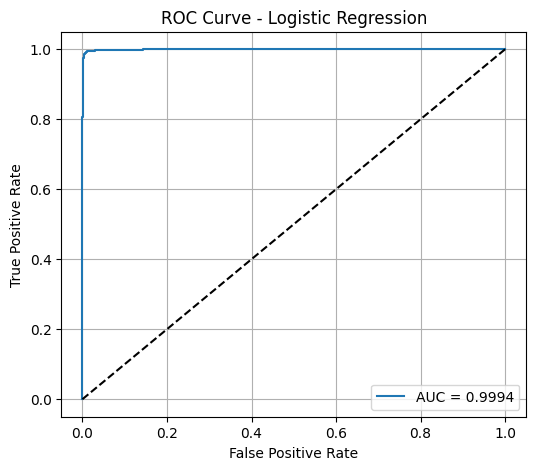

In [65]:
# ROC for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
auc_log = roc_auc_score(y_test, y_proba_log)

plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label=f'AUC = {auc_log:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

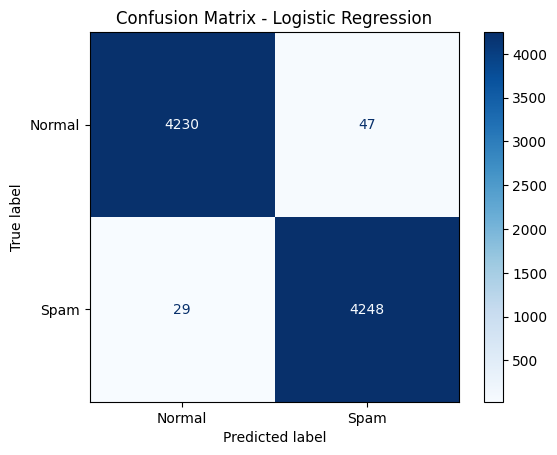

In [66]:
# Confusion matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)

disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=["Normal", "Spam"])
disp_log.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

In [67]:
# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,       # number of trees
    random_state=42,        # ensures reproducibility
    n_jobs=-1               # uses all CPU cores for training
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4277
           1       0.99      0.98      0.99      4277

    accuracy                           0.99      8554
   macro avg       0.99      0.99      0.99      8554
weighted avg       0.99      0.99      0.99      8554

ROC AUC Score: 0.9991302281906652


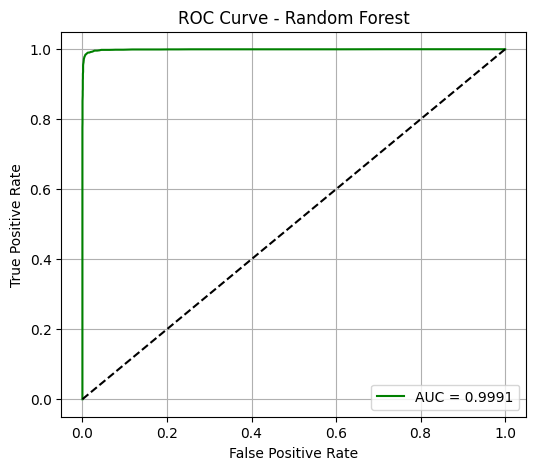

In [68]:
# ROC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {auc_rf:.4f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

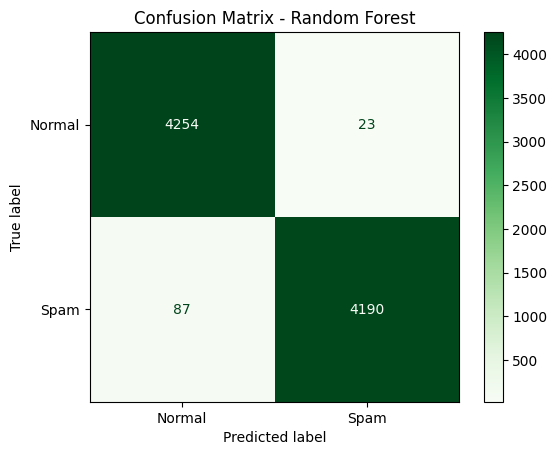

In [69]:
# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Normal", "Spam"])
disp_rf.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

In [70]:
comparison_data = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [log_model.score(X_test, y_test), rf_model.score(X_test, y_test)],
    "ROC_AUC": [roc_auc_score(y_test, y_proba_log), roc_auc_score(y_test, y_proba_rf)],
}
pd.DataFrame(comparison_data)

,Model,Accuracy,ROC_AUC
0,Logistic Regression,0.991115,0.999437
1,Random Forest,0.987141,0.999130


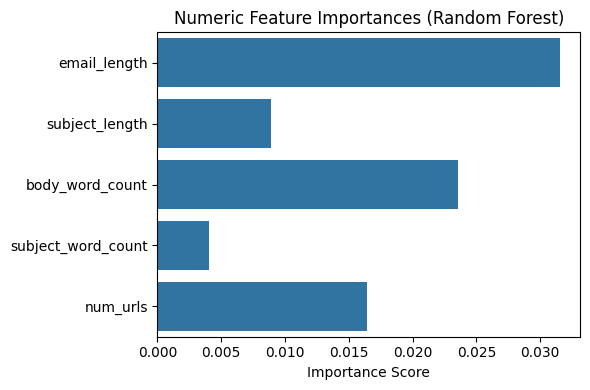

In [71]:
# Get numeric feature importances from Random Forest
importances = rf_model.feature_importances_[-X_numeric.shape[1]:]  # last features are numeric
feature_names = numeric_cols

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=feature_names)
plt.title("Numeric Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Naive Bayes:
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      4277
           1       0.99      0.68      0.81      4277

    accuracy                           0.84      8554
   macro avg       0.87      0.84      0.83      8554
weighted avg       0.87      0.84      0.83      8554

ROC AUC Score: 0.8359824004389942


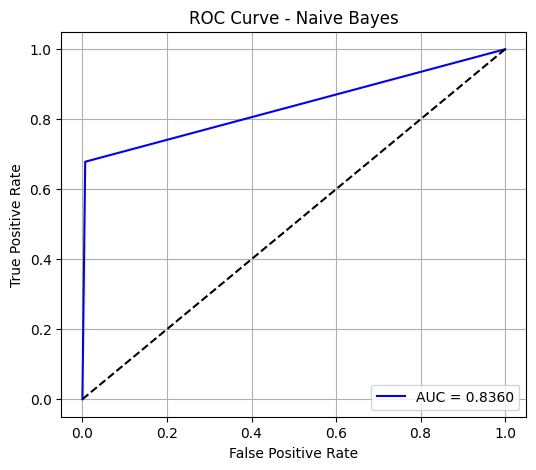

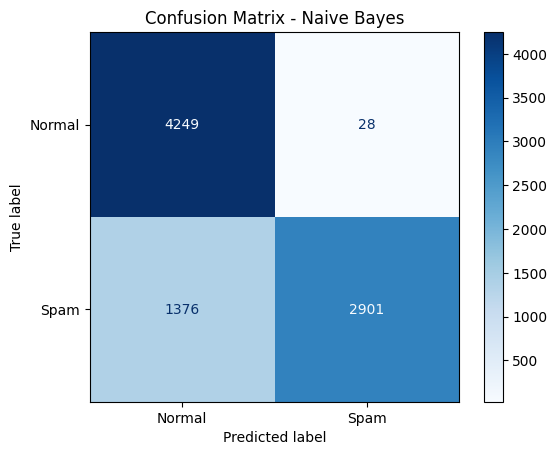

In [72]:
# Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)  # Convert sparse matrix to dense

y_pred_nb = nb_model.predict(X_test.toarray())
y_proba_nb = nb_model.predict_proba(X_test.toarray())[:, 1]

print("Naive Bayes:")
print(classification_report(y_test, y_pred_nb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_nb))

# ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
auc_nb = roc_auc_score(y_test, y_proba_nb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_nb, tpr_nb, label=f'AUC = {auc_nb:.4f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=["Normal", "Spam"])
disp_nb.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Naive Bayes")
plt.grid(False)
plt.show()
